# 第10回講義 演習

In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

rng = np.random.RandomState(42)

Using TensorFlow backend.


## 課題1. Recurrent Neural Network (RNN) Encoder-Decoderモデルで英日翻訳

### 1. データセットの読み込みと単語・品詞のID化

#### 1.1. データセットについて

train.enとtrain.jaの中身は次のようになっています.

train.enの中身 (英語の文)
```
i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
︙
```

train.jaの中身(日本語の文, 対訳)
```
誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
︙
```
(データセットにはTanaka Corpus ( http://www.edrdg.org/wiki/index.php/Tanaka_Corpus )の一部を抽出した 
small_parallel_enja: 50k En/Ja Parallel Corpus for Testing SMT Methods ( https://github.com/odashi/small_parallel_enja ) を使っています.)

#### 1.2. 単語・品詞のID化

単語のままだと扱いづらいので, それぞれの単語をIDに置き換えます. 以下のコードでは, まず`build_vocab`で単語->idの辞書(`w2i`)を作り, それを元に`encode`で各単語をid化しています.

In [2]:
def build_vocab(file_path):
    vocab = set()
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()
        vocab.update(words)

    w2i = {w: np.int32(i+2) for i, w in enumerate(vocab)}
    w2i['<s>'], w2i['</s>'] = np.int32(0), np.int32(1) # 文の先頭・終端記号

    return w2i

def encode(sentence, w2i):
    encoded_sentence = []
    for w in sentence:
        encoded_sentence.append(w2i[w])
    return encoded_sentence

def load_data(file_path, vocab=None, w2i=None):
    if vocab is None and w2i is None:
        w2i = build_vocab(file_path)
    
    data = []
    for line in open(file_path, encoding='utf-8'):
        s = line.strip().split()
        s = ['<s>'] + s + ['</s>']
        enc = encode(s, w2i)
        data.append(enc)
    i2w = {i: w for w, i in w2i.items()}
    return data, w2i, i2w

In [3]:
import os

In [4]:
# 英語->日本語
train_X, e_w2i, e_i2w = load_data('train.en')
train_y, j_w2i, j_i2w = load_data('train.ja')

train_X, _, train_y, _ = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # 演習用に縮小
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.02, random_state=42)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.02, random_state=42)

### 2. 各層クラスの実装

以下のクラスの中では, 系列中の全てのステップに対してまとめて処理をおこなう`f_prop`関数の他に, 1つのステップに対してのみ処理をおこなう`f_prop_test`関数を実装しています. 理由は後述します.

#### 2.1. 単語のEmbedding層

$m$ : emb_dim

$n$ : vocab_size

実際にEmbedding層の処理を担うembedding_lookupでは, 入力をone_hotベクトルに変換し, Embedding層の行列に掛け, 対応する列ベクトルを選択します.
![embedding](embedding.png)

In [5]:
class Embedding:
    def __init__(self, vocab_size, emb_dim, scale=0.08):
        self.V = tf.Variable(rng.randn(vocab_size, emb_dim).astype('float32') * scale, name='V')

    def f_prop(self, x):
        return tf.nn.embedding_lookup(self.V, x)
    
    def f_prop_test(self, x_t):
        return tf.nn.embedding_lookup(self.V, x_t)

#### 2.2. Long short-term memory (LSTM)

実装する式は次のようになります. ($\odot$は要素ごとの積)

- 入力ゲート: $\hspace{20mm}i_t = \sigma \left( W_{xi} x_t + W_{hi} h_{t-1} + b_i \right)$
- 忘却ゲート: $\hspace{20mm}f_t = \sigma \left( W_{xf} x_t + W_{hf} h_{t-1} + b_f \right)$  
- 出力ゲート: $\hspace{20mm}o_t = \sigma \left( W_{xo} x_t + W_{ho} h_{t-1} + b_o \right)$  
- セル:　　　 $\hspace{20mm}c_t = f_t \odot c_{t-1} + i_t \odot \tanh \left( W_{xc} x_t + W_{hc} h_{t-1} + b_c \right)$  
- 隠れ層: 　　$\hspace{20mm}h_t = o_t \odot \tanh \left( c_t \right)$  

単純なRNNでは各ステップの関数の戻り値は隠れ層のみ ($h_t$) でしたが, LSTMでは隠れ層とセル状態の2つ ($h_t, c_t$) となるので注意してください. またマスクに関しても両方に適用する必要があります.

In [6]:
class LSTM:
    def __init__(self, in_dim, hid_dim, m, h_0=None, c_0=None):
        self.in_dim = in_dim
        self.hid_dim = hid_dim

        # input gate
        self.W_xi = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xi')
        self.W_hi = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hi')
        self.b_i  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_i')
        
        # forget gate
        self.W_xf = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
        self.W_hf = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
        self.b_f  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_f')

        # output gate
        self.W_xo = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xo')
        self.W_ho = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_ho')
        self.b_o  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_o')

        # cell state
        self.W_xc = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xc')
        self.W_hc = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hc')
        self.b_c  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_c')

        # initial state
        self.h_0 = h_0
        self.c_0 = c_0

        # mask
        self.m = m

    def f_prop(self, x):
        def fn(tm1, x_and_m):
            h_tm1 = tm1[0]
            c_tm1 = tm1[1]
            x_t = x_and_m[0]
            m_t = x_and_m[1]
            # input gate
            i_t = tf.nn.relu(tf.matmul(x_t, self.W_xi) + tf.matmul(h_tm1, self.W_hi) + self.b_i)

            # forget gate
            f_t = tf.nn.relu(tf.matmul(x_t, self.W_xf) + tf.matmul(h_tm1, self.W_hf) + self.b_f)

            # output gate
            o_t = tf.nn.relu(tf.matmul(x_t, self.W_xo) + tf.matmul(h_tm1, self.W_ho) + self.b_o)

            # cell state
            c_t = f_t * c_tm1 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(h_tm1, self.W_hc) + self.b_c)
            c_t = m_t[:, np.newaxis] * c_t + (1. - m_t[:, np.newaxis]) * c_tm1 # Mask

            # hidden state
            h_t = o_t * tf.nn.tanh(c_t)
            h_t = m_t[:, np.newaxis] * h_t + (1. - m_t[:, np.newaxis]) * h_tm1 # Mask

            return [h_t, c_t]

        _x = tf.transpose(x, perm=[1, 0, 2])
        _m = tf.transpose(self.m)

        if self.h_0 == None:
            self.h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))
        if self.c_0 == None:
            self.c_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))

        h, c = tf.scan(fn=fn, elems=[_x, _m], initializer=[self.h_0, self.c_0])
        return tf.transpose(h, perm=[1, 0, 2]), tf.transpose(c, perm=[1, 0, 2])
    
    def f_prop_test(self, x_t):
        # input gate
        i_t = tf.nn.relu(tf.matmul(x_t, self.W_xi) + tf.matmul(self.h_0, self.W_hi) + self.b_i)

        # forget gate
        f_t = tf.nn.relu(tf.matmul(x_t, self.W_xf) + tf.matmul(self.h_0, self.W_hf) + self.b_f)

        # output gate
        o_t = tf.nn.relu(tf.matmul(x_t, self.W_xo) + tf.matmul(self.h_0, self.W_ho) + self.b_o)

        # cell state
        c_t = f_t * self.c_0 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(self.h_0, self.W_hc) + self.b_c)

        # hidden state
        h_t = o_t * tf.nn.tanh(c_t)

        return [h_t, c_t]

#### 2.3. 全結合層

`f_prop`における入力は3階テンソルとなるので, `tf.einsum`を使用します.

入力`x`と重み`W`のshapeは, それぞれ

- `x`: (ミニバッチサイズ, i) x (系列長, j) x (入力次元数, k)
- `W`: (入力次元数, k) x (出力次元数, l)

で, 出力は

- (ミニバッチサイズ, i) x (系列長, j) x (出力次元数, l)

となるので, `einsum`の第一引数の表記は`'ijk,kl->ijl'`となります.

In [7]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(tf.zeros([out_dim], dtype=tf.float32), name='b')
        self.function = function

    def f_prop(self, x):
        return self.function(tf.einsum('ijk,kl->ijl', x, self.W) + self.b)

    def f_prop_test(self, x_t):
        return self.function(tf.matmul(x_t, self.W) + self.b)

### 3. 計算グラフ構築 & パラメータの更新設定

下の図のモデルを実装します.

![seq2seq](seq2seq.png)

https://www.tensorflow.org/tutorials/seq2seq より引用

ミニバッチサイズ, 系列長, 辞書のサイズをそれぞれ$N$, $T$, $K$とすると, 多クラス交差エントロピー誤差関数は次のようになります.

$$
    E({\bf \theta}) = -\frac{1}{N}\sum^N_{n=1}\sum^T_{t=1}\sum^K_{k=1} d^{(n)}_{t, k} \log y^{(n)}_{t, k}
$$

Encoder, Decoderともに短い系列に対してはpaddingをします. また, Encoderではマスクを行います.

Decoderでpaddingした部分については, コストがゼロになるようにします. これは, 単語がある部分を1, paddingの部分を0とするバイナリのマスクをかけるか, paddingの部分の教師ラベルdの要素をすべてゼロになるようにします.

`tf`においては, `tf.one_hot`でone_hot化するときに範囲外の値(-1など)を入力とすれば, その値に対するベクトルはすべてゼロとなります. 以下ではこちらの方法で実装しています.

In [8]:
e_vocab_size = len(e_w2i)
j_vocab_size = len(j_w2i)
emb_dim = 256
hid_dim = 256

x = tf.placeholder(tf.int32, [None, None], name='x')
m = tf.cast(tf.not_equal(x, -1), tf.float32)
d = tf.placeholder(tf.int32, [None, None], name='d')
d_in = d[:, :-1]

d_out = d[:, 1:]
d_out_one_hot = tf.one_hot(d_out, depth=j_vocab_size, dtype=tf.float32)

def f_props(layers, x):
    for layer in layers:
        x = layer.f_prop(x)
    return x

encoder = [
    Embedding(e_vocab_size, emb_dim),
    LSTM(emb_dim, hid_dim, m)
]

h_enc, c_enc = f_props(encoder, x)

decoder_pre = [
    Embedding(j_vocab_size, emb_dim),
    LSTM(emb_dim, hid_dim, tf.ones_like(d_in, dtype='float32'), h_0=h_enc[:, -1, :], c_0=c_enc[:, -1, :]),
]

decoder_post = [
    Dense(hid_dim, j_vocab_size, tf.nn.softmax)
]

h_dec, c_dec = f_props(decoder_pre, d_in)
y = f_props(decoder_post, h_dec)

cost = -tf.reduce_mean(tf.reduce_sum(d_out_one_hot * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=[1, 2]))

train = tf.train.AdamOptimizer().minimize(cost)
#train = tf.train.RMSPropOptimizer(1e-3).minimize(cost)
#train = tf.train.RMSPropOptimizer(0.1).minimize(cost)
#train = tf.train.MomentumOptimizer(1e-4,0.99, use_nesterov = True).minimize(cost)

### 4. 学習

In [9]:
train_X_lens = [len(com) for com in train_X]
sorted_train_indexes = sorted(range(len(train_X_lens)), key=lambda x: -train_X_lens[x])

train_X = [train_X[ind] for ind in sorted_train_indexes]
train_y = [train_y[ind] for ind in sorted_train_indexes]

In [10]:
import time
start_time = time.time()
n_epochs = 40
batch_size = 128
n_batches = len(train_X) // batch_size

sess = tf.Session()

sess.run(tf.global_variables_initializer())

result=[]
for epoch in range(n_epochs):
    # train
    train_costs = []
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        train_X_mb = np.array(pad_sequences(train_X[start:end], padding='post', value=-1))
        train_y_mb = np.array(pad_sequences(train_y[start:end], padding='post', value=-1))

        _, train_cost = sess.run([train, cost], feed_dict={x: train_X_mb, d: train_y_mb})
        train_costs.append(train_cost)

    # valid
    #valid_X_mb = np.array(pad_sequences(valid_X, padding='post', value=-1))
    #valid_y_mb = np.array(pad_sequences(valid_y, padding='post', value=-1))

    #valid_cost = sess.run(cost, feed_dict={x: valid_X_mb, d: valid_y_mb})
    test_batch_size = 128
    n_batches_test = -(-len(test_X) // test_batch_size)
    test_costs = []
        
    for i in range(n_batches_test):
        start = i * test_batch_size
        end = start + test_batch_size if (start + test_batch_size) < len(test_X) else len(test_X)
            
        test_X_padded = np.array(pad_sequences(test_X[start:end], padding='post', value=-1))
        test_y_padded = np.array(pad_sequences(test_y[start:end], padding='post', value=-1))
            
        test_cost = sess.run(cost, feed_dict={x: test_X_padded, d: test_y_padded})
        test_costs.append(test_cost)
    print('EPOCH: %i, Training cost: %.3f, Validation cost: %.3f, Time: %i' % (epoch+1, np.mean(train_costs), np.mean(test_costs), time.time()-start_time))
    result.append(np.mean(test_costs))

EPOCH: 1, Training cost: 67.544, Validation cost: 44.162, Time: 31
EPOCH: 2, Training cost: 38.479, Validation cost: 38.435, Time: 58
EPOCH: 3, Training cost: 34.704, Validation cost: 36.597, Time: 86
EPOCH: 4, Training cost: 32.158, Validation cost: 36.331, Time: 115
EPOCH: 5, Training cost: 30.337, Validation cost: 36.147, Time: 143
EPOCH: 6, Training cost: 28.875, Validation cost: 35.707, Time: 171
EPOCH: 7, Training cost: 27.961, Validation cost: 36.590, Time: 200
EPOCH: 8, Training cost: 27.803, Validation cost: 36.381, Time: 228
EPOCH: 9, Training cost: 26.669, Validation cost: 36.421, Time: 257
EPOCH: 10, Training cost: 25.409, Validation cost: 36.223, Time: 285
EPOCH: 11, Training cost: 24.605, Validation cost: 35.893, Time: 313
EPOCH: 12, Training cost: 24.158, Validation cost: 36.869, Time: 341
EPOCH: 13, Training cost: 23.130, Validation cost: 37.881, Time: 370
EPOCH: 14, Training cost: 26.859, Validation cost: 35.819, Time: 398
EPOCH: 15, Training cost: 24.429, Validation c

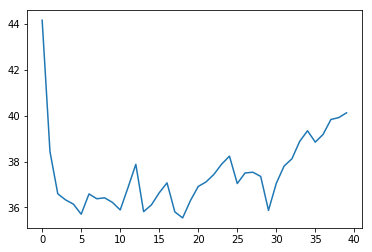

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(result)
plt.show()

### 5. 生成

翻訳文の生成には`while`ループを使うので, まず`tf`におけるwhileループの実装である`tf.while_loop`について説明します.

####  5.1. `tf.while_loop`関数  \[[link\]](https://www.tensorflow.org/api_docs/python/tf/while_loop)

主な引数は以下のとおりです.

- 第1引数 `cond`: `True` or `False` を返す関数 (正確にはcallable)
- 第2引数 `body`: 各iterationで実行する関数 (正確にはcallable)
- 第3引数 `loop_vars`: `cond`及び`body`に最初に渡される変数

`cond`で指定された関数の戻り値が`True`である限り`body`で指定された関数を実行し続けます. そして, `loop_vars`で指定された全ての変数に対して, 最後のiteration後の値を返します.

例えば, 入力が5未満であるかぎり1ずつ足す処理を実行したい場合, コードは次のようになります.

In [12]:
g0 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成

def cond(z):
    return z < 5

def body(z):
    return z + 1

with g0.as_default():
    z = tf.constant(0)

    res = tf.while_loop(cond, body, [z])

with tf.Session(graph=g0) as sess_g0:
    print(sess_g0.run(res))

5


また, `tf.while_loop`の各iteration後の変数の`shape`はデフォルトでは同じであることが指定されています. なので, 各iteration後の`shape`が変化する場合は, この条件を緩和する必要があります.

たとえば, 上の1ずつ足すプログラムですべてのiteration後の値を保持して返したい場合, 各iterationの戻り値は

```
[1], [1, 2], [1, 2, 3], [1, 2, 3, 4], ...
```
となっていくので, それぞれの`shape`は,
```
(1,), (2,), (3,), (4,), ...
```
と変化していきます. つまり, この例ではベクトルの次元数が変化していくので, `shape_invariants`で`shape`を`[None]` (実際は`tf.TensorShape([None])`と指定します.

具体的なコードは次のようになります.

In [13]:
g1 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成

def cond(z):
    return z[-1] < 5

def body(z):
    return tf.concat([z, z[-1:]+1], axis=0)

with g1.as_default():
    z = tf.zeros(1)

    res = tf.while_loop(
        cond,
        body,
        [z],
        shape_invariants=[tf.TensorShape([None])]
    )

with tf.Session(graph=g1) as sess_g1:
    print(sess_g1.run(res))

[ 0.  1.  2.  3.  4.  5.]


2x1行列に対して同じような操作をしたい場合は次のようになります. この場合各iteration後の行列の`shape`は
```
(2, 1), (2, 2), (2, 3), (2, 4), ...
```
と列数のみ変化していくので, `shape_invariants`には`tf.TensorShape([2, None])`と指定します.

In [14]:
g2 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成


def cond(z):
    return tf.reduce_sum(z[:, -1]) < 5*2

def body(z):
    return tf.concat([z, z[:, -1:]+1], axis=1)

with g2.as_default():
    z = tf.zeros([2, 1])

    res = tf.while_loop(
        cond,
        body,
        [z],
        shape_invariants=[tf.TensorShape([2, None])]
    )

with tf.Session(graph=g2) as sess_g2:
    print(sess_g2.run(res))

[[ 0.  1.  2.  3.  4.  5.]
 [ 0.  1.  2.  3.  4.  5.]]


詳細は公式のドキュメントを参照してください.

- tf.while_loop: https://www.tensorflow.org/api_docs/python/tf/while_loop

#### 5.2. グラフの構築

未知のデータに対してEncoder-Decoderモデルを適用するとき, 正解ラベル$d$はわからないので, 代わりに前のステップで予測した単語を各ステップでの入力とします. そして, 系列の終わりを表す単語 (`</s>`) が出力されるまで繰り返します.

具体的には, $h_{t-1}, c_{t-1}, y_{t-1}$を入力として$y_t$を受け取る操作を, バッチ内の全てのサンプルにおける$y_t$が`</s>`となるまで続けます.

毎iterationで1つのステップについてのみ順伝播を計算すれば良いので, ここで各クラスの`f_prop_test`関数を使用します.

In [15]:
t_0 = tf.constant(0)
y_0 = tf.placeholder(tf.int32, [None, None], name='y_0')
h_0 = tf.placeholder(tf.float32, [None, None], name='h_0')
c_0 = tf.placeholder(tf.float32, [None, None], name='c_0')
f_0 = tf.cast(tf.zeros_like(y_0[:, 0]), dtype=tf.bool) # バッチ内の各サンプルに対して</s>が出たかどうかのflag
f_0_size = tf.reduce_sum(tf.ones_like(f_0, dtype=tf.int32))
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def f_props_test(layers, x_t):
    for layer in layers:
        x_t = layer.f_prop_test(x_t)
    return x_t

def cond(t, h_t, c_t, y_t, f_t):
    num_true = tf.reduce_sum(tf.cast(f_t, tf.int32)) # Trueの数
    unfinished = tf.not_equal(num_true, f_0_size)
    return tf.logical_and(t+1 < max_len, unfinished)

def body(t, h_tm1, c_tm1, y, f_tm1):
    y_tm1 = y[:, -1]

    decoder_pre[1].h_0 = h_tm1
    decoder_pre[1].c_0 = c_tm1
    h_t, c_t = f_props_test(decoder_pre, y_tm1)
    y_t = tf.cast(tf.argmax(f_props_test(decoder_post, h_t), axis=1), tf.int32)

    y = tf.concat([y, y_t[:, np.newaxis]], axis=1)

    f_t = tf.logical_or(f_tm1, tf.equal(y_t, 1)) # flagの更新

    return [t+1, h_t, c_t, y, f_t]

res = tf.while_loop(
    cond,
    body,
    loop_vars=[t_0, h_0, c_0, y_0, f_0],
    shape_invariants=[
        t_0.get_shape(),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None])
    ]
)

#### 5.3. 初期値$h_0, c_0, y_0$の獲得

In [16]:
valid_X_mb = pad_sequences(valid_X, padding='post', value=-1)
_y_0 = np.zeros_like(valid_X, dtype='int32')[:, np.newaxis]
_h_enc, _c_enc = sess.run([h_enc, c_enc], feed_dict={x: valid_X_mb})
_h_0 = _h_enc[:, -1, :]
_c_0 = _c_enc[:, -1, :]

#### 5.3. 生成

In [17]:
_, _, _, pred_y, _ = sess.run(res, feed_dict={
    y_0: _y_0,
    h_0: _h_0,
    c_0: _c_0,
    max_len: 100
})

#### 5.4. 生成例

In [18]:
num = 0

origy = valid_X[num][1:-1]
predy = list(pred_y[num])
truey = valid_y[num][1:-1]

print('元の文:', ' '.join([e_i2w[com] for com in origy]))
print('生成文された文:', ' '.join([j_i2w[com] for com in predy[1:predy.index(1)]]))
print('正解文:', ' '.join([j_i2w[com] for com in truey]))

元の文: get back , get back .
生成文された文: そう な り ま し た 。
正解文: 戻 っ て お い で 戻 っ て お い で よ 。
